<a href="https://colab.research.google.com/github/kghilothia06/Time-Series-Forecasting/blob/main/01_LSTM_univariate_car_sales_14_6_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LSTM examples for monthly and quarterly sales prediction

Import Libraries

In [1]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
  return data[:-n_test], data[-n_test:]


In [3]:
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
  df = DataFrame(data)
  cols = list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
  # put it all together
  agg = concat(cols, axis=1)
  # drop rows with NaN values
  agg.dropna(inplace=True)
  return agg.values


In [4]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
  # round calculated RMSE to nearest integer
  return int(sqrt(mean_squared_error(actual, predicted)))


In [5]:
# difference dataset
def difference(data, interval):
  return [data[i] - data[i - interval] for i in range(interval, len(data))]

In [6]:
# fit a model
def model_fit(train, config):
  # unpack config
  n_input, n_nodes, n_epochs, n_batch, n_diff = config
  # prepare data
  if n_diff > 0:
    train = difference(train, n_diff)
  data = series_to_supervised(train, n_input)
  train_x, train_y = data[:, :-1], data[:, -1]
  train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
  # define model
  model = Sequential()
  model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
  # fit
  model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
  return model


In [7]:
# forecast with a pre-fit model
def model_predict(model, history, config):
  # unpack config
  n_input, _, _, _, n_diff = config
  # prepare data
  correction = 0.0
  if n_diff > 0:
    correction = history[-n_diff]
    history = difference(history, n_diff)
  x_input = array(history[-n_input:]).reshape((1, n_input, 1))
  # forecast
  yhat = model.predict(x_input, verbose=0)
  return correction + yhat[0]

In [8]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
  predictions = list()
  # split dataset
  train, test = train_test_split(data, n_test)
  # fit model
  model = model_fit(train, cfg)
  # seed history with training dataset
  history = [x for x in train]
  # step over each time-step in the test set
  for i in range(len(test)):
    # fit model and make forecast for history
    yhat = model_predict(model, history, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add predicted observation to history for the next loop
    history.append(yhat)

  # calculate R2 score
  rsqaure = r2_score(test, predictions)
  print('R squared score : ' + str(rsqaure))
  # estimate prediction error
  error = measure_rmse(test, predictions)
  print('RMSE : ' +  str(error))
  return train, test, predictions, error


In [9]:
# summarize model performance
def summarize_scores(name, score):
  # print a summary
  # Here, no need to calculate mean and standard deviation as there will only be 1 score ( since repeats = 1)
  print('Name : ' + str(name) + ' --> ' + 'Score : ' + str(score))
  # box and whisker plot
  pyplot.boxplot(score)
  pyplot.show()

## Read quarterly dataset

**In order to change how many last values need to be predicted: 
Kindly modify the 'n_test' variable in the below two cells (separately for quarterly and monthly predictions)** 

R squared score : 0.34694356760044454
RMSE : 134776
Name : lstm --> Score : 134776


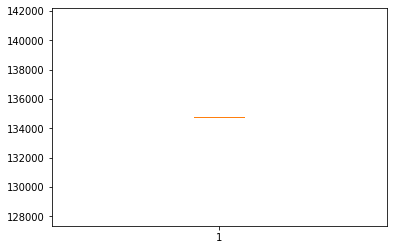

In [10]:
series_original = read_csv('/content/Quarterly_Revenue_March_21.csv', header=0, index_col=0)
series = DataFrame(series_original['Revenue'])
data = series.values
# data split
n_test = 4
# define config = [n_input, n_nodes, n_epochs, n_batch, n_diff] 
# n_input: The number of lag observations to use as input to the model.
# n_nodes: The number of LSTM units to use in the hidden layer.
# n_epochs: The number of times to expose the model to the whole training dataset.
# n_batch: The number of samples within an epoch after which the weights are updated.
# n_diff: The difference order or 0 if not used
config = [1, 8, 10, 4, 4]
# calling walk forwward validation function
train, test, predictions, error = walk_forward_validation(data,n_test,config)
# summarize scores
summarize_scores('lstm', error)


# Add Graph for quarterly prediction

In [11]:
# reset columns
series_original.reset_index(level=0, inplace=True)

In [12]:
# convert 'Year' and 'Qaurter' column to string type
series_original = series_original.astype({"Year": str, "Quarter": str})

In [13]:
# concatenate first two columns
series_original['Quarter'] = series_original['Year'] + '-' + series_original['Quarter']

In [14]:
# set x axis labels
x_axis_label = []
#dictionary to keep track of current year
vis = {}
vis[2017] = 0
vis[2018] = 0
vis[2019] = 0
vis[2020] = 0
vis[2021] = 0
for i in range(len(series_original)):
  if vis[int(series_original.iloc[i,0])] == 0:
    vis[int(series_original.iloc[i,0])] = 1
    x_axis_label.append(str(series_original.iloc[i,0]))
  else:
    x_axis_label.append(' ')

x_axis_label

['2017',
 ' ',
 ' ',
 ' ',
 '2018',
 ' ',
 ' ',
 ' ',
 '2019',
 ' ',
 ' ',
 ' ',
 '2020',
 ' ',
 ' ',
 ' ',
 '2021']

In [15]:
# separate dates for test and training data
dates_train = []
for i in range(len(series_original)-n_test):
  dates_train.append(series_original['Quarter'][i])

dates_train


dates_test = []
for i in range(len(series_original)-n_test , len(series_original)):
  dates_test.append(series_original['Quarter'][i])

dates_test

['2020-2', '2020-3', '2020-4', '2021-1']

In [16]:
dates_train

['2017-1',
 '2017-2',
 '2017-3',
 '2017-4',
 '2018-1',
 '2018-2',
 '2018-3',
 '2018-4',
 '2019-1',
 '2019-2',
 '2019-3',
 '2019-4',
 '2020-1']

In [17]:
# set prediction interval for each forecast
confidence_upper = []
confidence_lower = []
for i in predictions:
  x1 = (i+1.96*(array(predictions).std()))
  confidence_upper.append(x1[0])
  y1 = (i-1.96*(array(predictions).std()))
  confidence_lower.append(y1[0])

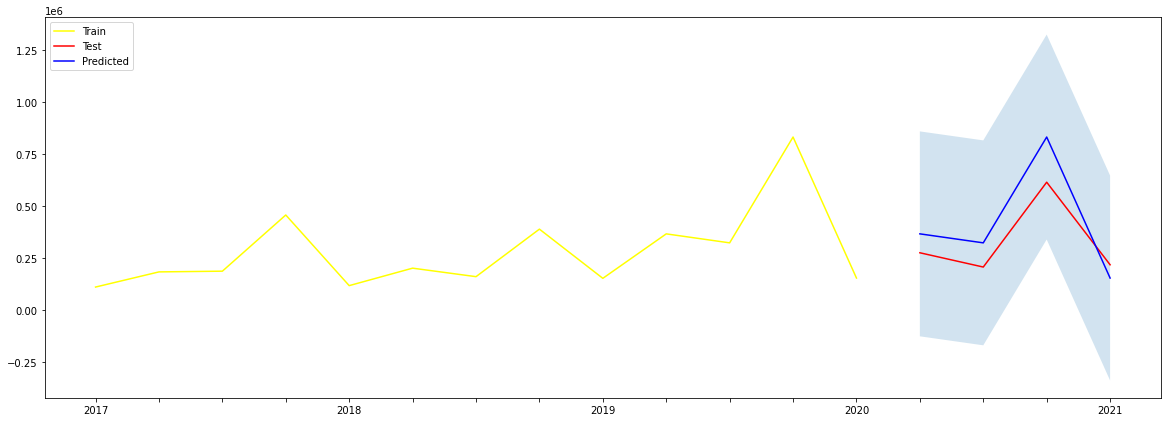

In [18]:
# Plot Graph
plt.figure(figsize=(20,7))
plt.plot(dates_train, train, color='yellow', label="Train")
plt.plot(dates_test, test, color='red', label="Test")
plt.plot(dates_test, predictions, color='blue', label="Predicted")
plt.legend(loc="upper left")
plt.fill_between(dates_test, confidence_upper, confidence_lower, alpha=0.2)
plt.xticks(np.arange(len(x_axis_label)), x_axis_label)

plt.show()

## Read monthly dataset

R squared score : 0.7481162294850942
RMSE : 64555
Name : lstm --> Score : 64555


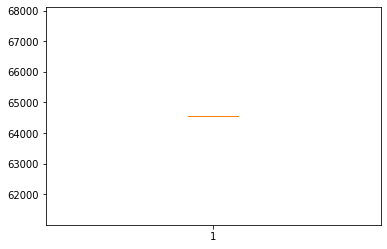

In [19]:
series_original = read_csv('/content/Monthly_Revenue_March_21.csv', header=0, index_col=0)
series = DataFrame(series_original['Revenue'])
data = series.values
# data split
n_test = 14
# define config = [n_input, n_nodes, n_epochs, n_batch, n_diff] 
# n_input: The number of lag observations to use as input to the model.
# n_nodes: The number of LSTM units to use in the hidden layer.
# n_epochs: The number of times to expose the model to the whole training dataset.
# n_batch: The number of samples within an epoch after which the weights are updated.
# n_diff: The difference order or 0 if not used
config = [5, 32, 10, 12, 12]
# calling walk forwward validation function
train, test, predictions, error = walk_forward_validation(data,n_test,config)
# summarize scores
summarize_scores('lstm', error)


# Add Graph for Monthly prediction

In [20]:
# reset columns
series_original.reset_index(level=0, inplace=True)

In [21]:
# convert 'Year' and 'Month' column to string type
series_original = series_original.astype({"Year": str, "Month": str})

In [22]:
# concatenate first two columns
series_original['Month'] = series_original['Year'] + '-' + series_original['Month']

In [23]:
series_original.drop(['Year'], axis=1, inplace=True)

In [24]:
# set x axis labels
x_axis_label = []

for i in range(len(series_original)):
  if series_original.iloc[i,0][-2:] == '-1':
    x_axis_label.append(series_original.iloc[i,0][:-2])
  else:
    x_axis_label.append(' ')

x_axis_label

['2017',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '2018',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '2019',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '2020',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '2021',
 ' ',
 ' ']

In [25]:
# separate dates for test and training data
dates_train = []
for i in range(len(series_original)-n_test):
  dates_train.append(series_original['Month'][i])

dates_train


dates_test = []
for i in range(len(series_original)-n_test , len(series_original)):
  dates_test.append(series_original['Month'][i])

dates_test

['2020-2',
 '2020-3',
 '2020-4',
 '2020-5',
 '2020-6',
 '2020-7',
 '2020-8',
 '2020-9',
 '2020-10',
 '2020-11',
 '2020-12',
 '2021-1',
 '2021-2',
 '2021-3']

In [26]:
# set prediction interval for each forecast
confidence_upper = []
confidence_lower = []
for i in predictions:
  x1 = (i+1.96*(array(predictions).std()))
  confidence_upper.append(x1[0])
  y1 = (i-1.96*(array(predictions).std()))
  confidence_lower.append(y1[0])

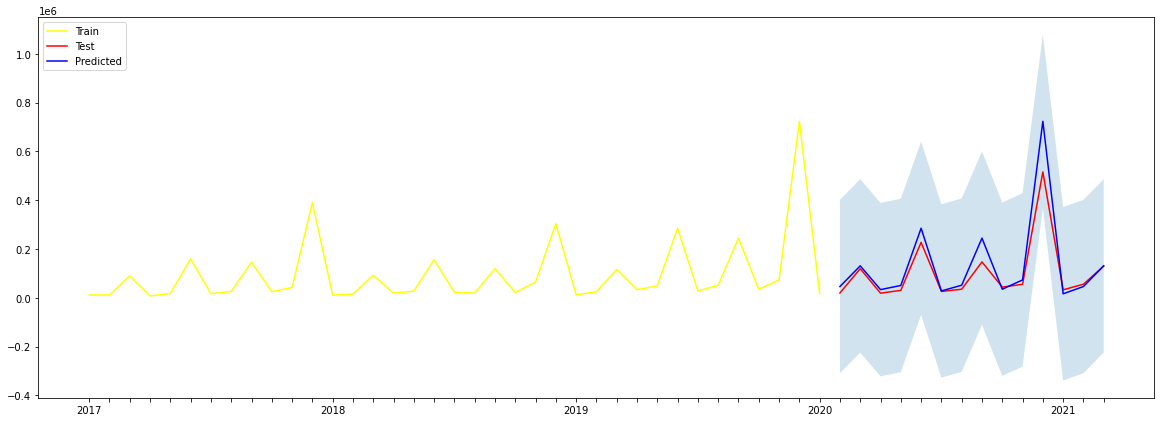

In [27]:
# Plot Graph
plt.figure(figsize=(20,7))
plt.plot(dates_train, train, color='yellow', label="Train")
plt.plot(dates_test, test, color='red', label="Test")
plt.plot(dates_test, predictions, color='blue', label="Predicted")
plt.legend(loc="upper left")
plt.fill_between(dates_test, confidence_upper, confidence_lower, alpha=0.2)
plt.xticks(np.arange(len(x_axis_label)), x_axis_label)

plt.show()